In [84]:
using Pkg; Pkg.activate("."); #Pkg.add("DelimitedFiles")
using MUST
using PyPlot
using LaTeXStrings
using DelimitedFiles
using TSO

MUST.@import_dispatch "/u/peitner/DISPATCH/dispatch2"       # Importing dispatch in general and set the paths
MUST.@import_dispatch "/u/peitner/DISPATCH/dispatch2" EOS   # Importing the dispatch EOS python for the legacy EoS
MUST.@get_help visual; 

  Activating environment at `/cobra/ptmp/peitner/model_grid/MUST.jl/examples/EoS/Project.toml`


# Import the EoS' of interest
Import them directly in the way they are read in dispatch.

In [85]:
## Different Squaregas EoS to test
eos = [#MUST.SquareGasEOS(MUST.@in_dispatch("input_data/TSO_LEG_Binned_v1.1")),
       MUST.SquareGasEOS(MUST.@in_dispatch("input_data/TSO_sun_Magg_v10.2")),
       #MUST.SquareGasEOS(MUST.@in_dispatch("input_data/DIS_AESOPUS_v1.3.2")),
       MUST.SquareGasEOS(MUST.@in_dispatch("input_data/DISSTAG_v0.1")),
       MUST.SquareGasEOS(MUST.@in_dispatch("input_data/DIS_MARCS_v0.1.1")),
       MUST.SquareGasEOS(MUST.@in_dispatch("input_data/solar_lte"))]

## 4 Bins legacy EoS directly from DISPATCH
leEos = MUST.@legacyPythonEOS ;

In [86]:
## Also import them in the TSO interface to check for errors
path = MUST.@in_dispatch("input_data/LegacyStagger_sun")
eos_direct = TSO.reload(TSO.SqEoS, joinpath(path, "eos.hdf5"))
opa_direct = TSO.reload(TSO.SqOpacity, joinpath(path, "binned_opacities.hdf5"));

In [87]:
## Plotting setup
color  = colors("rainbow", length(eos)+1) 
labels = ["Legacy Stagger 12 bins", "AESOPUS + TS", "TSO", "MARCS", "TAB"]
labels = ["TSO", "DIS-STAGGER", "MARCS", "TAB"]
ls     = ["-", "-", "-", "-", "-"];

They contain the EoS as well as the opacities on the same rho-E grid.

In [88]:
units = MUST.StaggerCGS();

In [89]:
## Legacy EoS limits
e0, e1 = convert.(Float64, MUST.limits(leEos)[3:4]);

# Solar Model
We compare the EoS for a typical average solar model.

In [90]:
path  = abspath.("stagger_av.dat")
model = reverse(readdlm(path, skipstart=2), dims=1)
z_profile, T_profile, d_profile = model[:, 1], model[:, 2], exp.(model[:, 3]);

In [91]:
## We need to lookup the internal energy using the respective EoS
e_profile_stagger = Float64[MUST.bisect(leEos, ee=[e0, e1], d=d_profile[i] ./units.d, T=T_profile[i]) for i in eachindex(d_profile)] .* units.ee;
e_profile_sq      = []

for i in eachindex(eos)
    eemin, eemax = MUST.limits(eos[i])[3:4]
    append!(e_profile_sq, [Float64[MUST.bisect(eos[i], ee=[eemin, eemax], d=d_profile[j], T=T_profile[j]) for j in eachindex(d_profile)]])
end;

In [92]:
log.(d_profile)

236-element Vector{Float64}:
 -23.180305
 -23.038437
 -22.898151
 -22.757418
 -22.616014
 -22.472094
 -22.326553
 -22.17929
 -22.030994
 -21.881187
   ⋮
 -10.668339
 -10.651318
 -10.634495
 -10.617719
 -10.600883
 -10.584326
 -10.567569
 -10.551072
 -10.534594

# EoS

In [93]:
get_close(rho, rho_arr) = argmin(abs.(rho .- rho_arr))
e_shifted(e, offset)    = log(exp(e) + offset)
mean = MUST.mean;

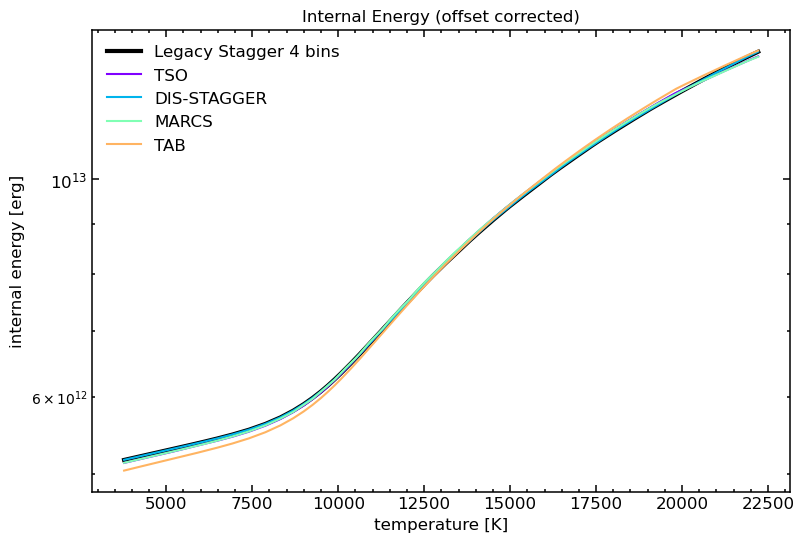

In [94]:
close()
f, ax = plt.subplots(1, 1, figsize=(9,6))
basic_plot!(ax)

## Title
ax.set_title("Internal Energy (offset corrected)")

## Plotting 
### Legacy
ax.plot(T_profile, e_profile_stagger, marker="", color="k",label="Legacy Stagger 4 bins", lw=3)

## Squaregas
for i in eachindex(eos)
    offset = mean(e_profile_stagger .- e_profile_sq[i])
    ax.plot(T_profile, e_profile_sq[i] .+ offset, color=color[i], ls=ls[i], label=labels[i])
end

## setup
ax.set_yscale("log")
ax.set_xlabel("temperature [K]", fontsize="large")
ax.set_ylabel("internal energy [erg]", fontsize="large")
ax.legend(fontsize="large", framealpha=0)

gcf()

Every other quantity we can simply lookup in the table

In [95]:
pg_stagger = MUST.lookup(leEos, :P, d_profile ./units.d, e_profile_stagger ./units.ee) .*units.p;

pg_sq = []
for i in eachindex(eos)
    append!(pg_sq, [MUST.lookup(eos[i], :Pg, d_profile, e_profile_sq[i])])
end;

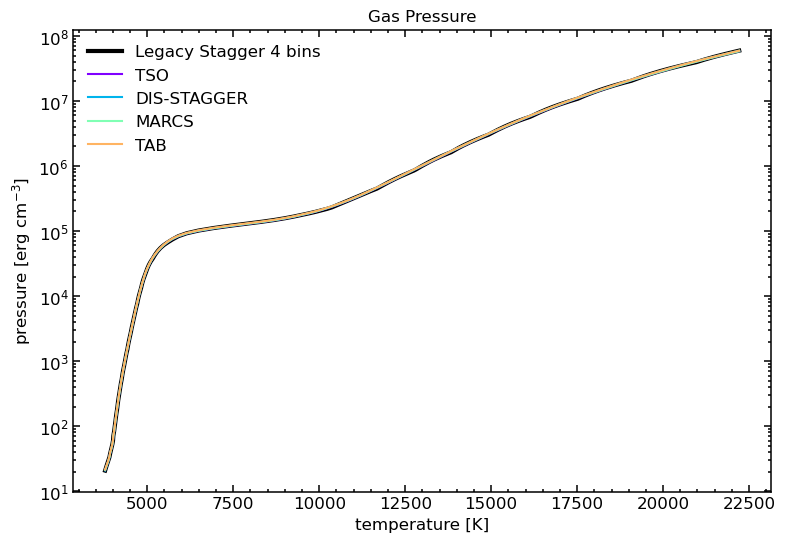

In [96]:
close()
f, ax = plt.subplots(1, 1, figsize=(9,6))
basic_plot!(ax)

## Title
ax.set_title("Gas Pressure")

## Plotting 
### Legacy
ax.plot(T_profile, pg_stagger, marker="", color="k",label="Legacy Stagger 4 bins", lw=3)

## Squaregas
for i in eachindex(eos)
    ax.plot(T_profile, pg_sq[i], color=color[i], ls=ls[i], label=labels[i])
end

## setup
ax.set_yscale("log")
ax.set_xlabel("temperature [K]", fontsize="large")
ax.set_ylabel(L"\rm pressure\ [erg\ cm^{-3}]", fontsize="large")
ax.legend(fontsize="large", framealpha=0)

gcf()

# Opacities
For comparison, we also load the table in the TSO format to check if something went wrong there

In [97]:
lne_ts = TSO.lookup(@axed(eos_direct), :lnEi, log.(d_profile), log.(T_profile));

In [98]:
units.m ./ units.t^3

1.0e11

In [99]:
k_stagger = zeros(length(d_profile), 4)
k_stagger[:, 1] = MUST.lookup(leEos, :K1, d_profile ./units.d, e_profile_stagger ./units.ee) .*units.rk 
k_stagger[:, 2] = MUST.lookup(leEos, :K2, d_profile ./units.d, e_profile_stagger ./units.ee) .*units.rk
k_stagger[:, 3] = MUST.lookup(leEos, :K3, d_profile ./units.d, e_profile_stagger ./units.ee) .*units.rk
k_stagger[:, 4] = MUST.lookup(leEos, :K4, d_profile ./units.d, e_profile_stagger ./units.ee) .*units.rk

k_sq = []
for i in eachindex(eos)
    append!(k_sq, [MUST.lookup(eos[i], :rk, d_profile, e_profile_sq[i])])
end;

#k_sq[1] ./= d_profile

#k_ts = zeros(eltype(lne_ts), length(lne_ts), length(opa_direct.λ))
#for i in eachindex(opa_direct.λ)
#    k_ts[:, i] .= exp.(TSO.lookup(eos_direct, opa_direct, :κ, log.(d_profile), lne_ts, i))
#end;

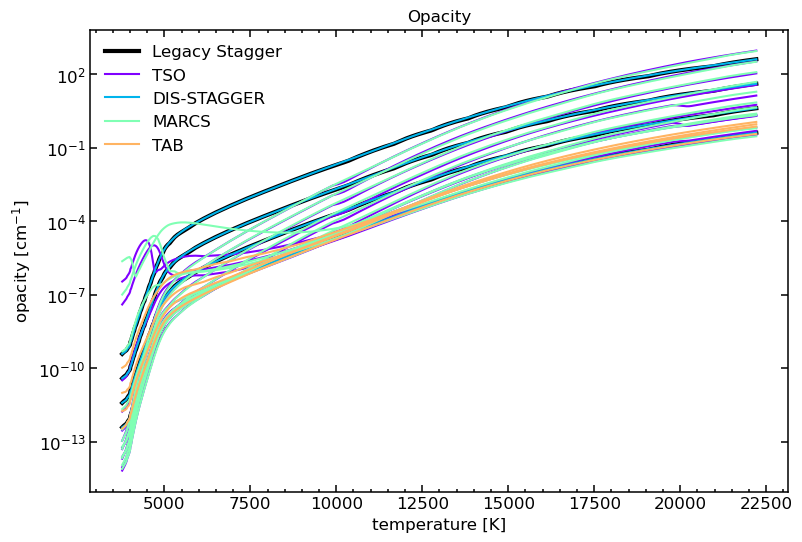

In [100]:
close()
f, ax = plt.subplots(1, 1, figsize=(9,6))
basic_plot!(ax)

## Title
ax.set_title("Opacity")

## overplot all opacities
## Stagger
ax.plot(T_profile, k_stagger[:, 1], marker="", color="k",label="Legacy Stagger", lw=3)
ax.plot(T_profile, k_stagger[:, 2], marker="", color="k", lw=3)
ax.plot(T_profile, k_stagger[:, 3], marker="", color="k", lw=3)
ax.plot(T_profile, k_stagger[:, 4], marker="", color="k", lw=3)

## Squaregas
for i in eachindex(eos)
    for j in axes(k_sq[i], 2)
        if j==1 
            ax.plot(T_profile, k_sq[i][:, j], color=color[i], ls=ls[i], label=labels[i])
        else
            ax.plot(T_profile, k_sq[i][:, j], color=color[i], ls=ls[i])
        end
    end
end

## Plot it directly from the TS format
#=for j in axes(k_ts, 2)
    if j==1 
        ax.plot(T_profile, k_ts[:, j], color=color[end], label="Legacz in TS format")
    else
        ax.plot(T_profile, k_ts[:, j], color=color[end])
    end
end=#

## setup
ax.set_yscale("log")
ax.set_xlabel("temperature [K]", fontsize="large")
ax.set_ylabel(L"\rm opacity\ [cm^{-1}]", fontsize="large")
ax.legend(fontsize="large", framealpha=0)

gcf()

In [101]:
s_stagger = zeros(length(d_profile), 4)
s_stagger[:, 1] = MUST.lookup(leEos, :S1, d_profile ./units.d, e_profile_stagger ./units.ee) .*units.m ./ units.t^3
s_stagger[:, 2] = MUST.lookup(leEos, :S2, d_profile ./units.d, e_profile_stagger ./units.ee) .*units.m ./ units.t^3
s_stagger[:, 3] = MUST.lookup(leEos, :S3, d_profile ./units.d, e_profile_stagger ./units.ee) .*units.m ./ units.t^3
s_stagger[:, 4] = MUST.lookup(leEos, :S4, d_profile ./units.d, e_profile_stagger ./units.ee) .*units.m ./ units.t^3

s_sq = []
for i in eachindex(eos)
    append!(s_sq, [MUST.lookup(eos[i], :src, d_profile, e_profile_sq[i])])
end;

#s_ts = zeros(eltype(lne_ts), length(lne_ts), length(opa_direct.λ))
#for i in eachindex(opa_direct.λ)
#    s_ts[:, i] .= exp.(TSO.lookup(eos_direct, opa_direct, :src, log.(d_profile), lne_ts, i))
#end;

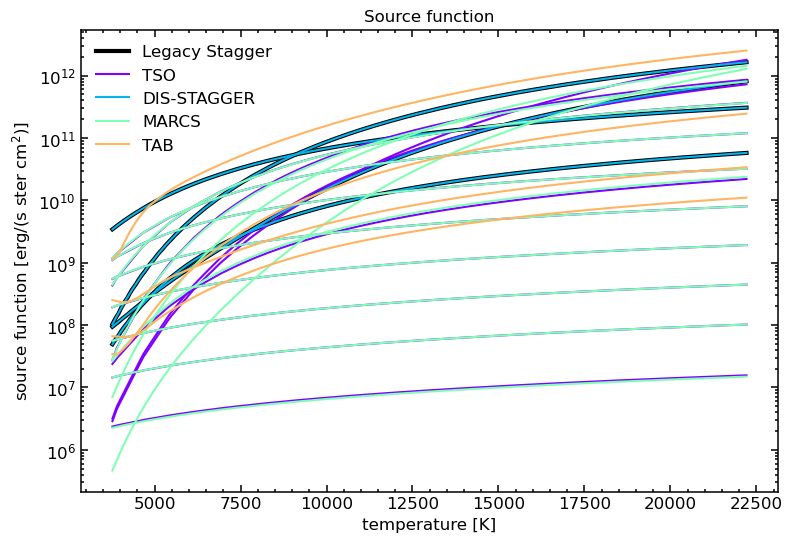

In [102]:
close()
f, ax = plt.subplots(1, 1, figsize=(9,6))
basic_plot!(ax)

## Title
ax.set_title("Source function")

## overplot all opacities
## Stagger
ax.plot(T_profile, s_stagger[:, 1], marker="", color="k",label="Legacy Stagger", lw=3)
ax.plot(T_profile, s_stagger[:, 2], marker="", color="k", lw=3)
ax.plot(T_profile, s_stagger[:, 3], marker="", color="k", lw=3)
ax.plot(T_profile, s_stagger[:, 4], marker="", color="k", lw=3)

## Squaregas
for i in eachindex(eos)
    for j in axes(k_sq[i], 2)
        if j==1 
            ax.plot(T_profile, s_sq[i][:, j], color=color[i], ls=ls[i], label=labels[i])
        else
            ax.plot(T_profile, s_sq[i][:, j], color=color[i], ls=ls[i])
        end
    end
end

## Plot it directly from the TS format
#=for j in axes(k_ts, 2)
    if j==1 
        ax.plot(T_profile, s_ts[:, j], color=color[end], label="Legacz in TS format")
    else
        ax.plot(T_profile, s_ts[:, j], color=color[end])
    end
end=#

## setup
ax.set_yscale("log")
ax.set_xlabel("temperature [K]", fontsize="large")
ax.set_ylabel(L"\rm source\ function\ [erg/(s\ ster\ cm^{2})]", fontsize="large")
ax.legend(fontsize="large", framealpha=0)

gcf()